In [4]:
# Colab imports

#from google.colab import drive
#drive.mount('/content/drive')
#from tqdm.notebook import tqdm

In [17]:
# Imports
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import statsmodels.api as sm
from scipy.stats import norm


# Seeds
import random, os
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [18]:
# read data

#df_ibm = pd.read_csv("/content/drive/MyDrive/data/stocks/Apple.csv")
#data_folder = "/content/drive/MyDrive/data/stocks/"
#stock_files = glob.glob(os.path.join(data_folder, "*.csv"))

In [29]:
def preprocess_stock(df_raw, patch_len: int, train_frac: float, val_frac: float, 
                     add_calendar: bool = False, add_har_features: bool = False):
    minutely = df_raw.copy()

    # turn column to datetime, add helper day column
    minutely["Date Time"] = pd.to_datetime(minutely["Date Time"])
    minutely = minutely.sort_values("Date Time")
    minutely["day"] = minutely["Date Time"].dt.date

    # minutely log returns withing days from close
    minutely["log_close"] = np.log(minutely["Close"].astype(float))
    minutely["ret_1m"] = minutely.groupby("day")["log_close"].diff()
    # remove first minute of each day without returns
    minutely = minutely[minutely["Date Time"].dt.time != pd.to_datetime("09:35").time()]

    # compute daily RV
    daily = (minutely.groupby("day")["ret_1m"]
               .agg(rv=lambda x: np.sum(x**2))
               .reset_index())
    # in case there is a zero RV, replace it with small value before log
    daily["log_rv"] = np.log(daily["rv"].replace(0.0, 1e-12))
     # label for inputs from day d is log_rv of day d+1
    daily["log_rv_tomorrow"] = daily["log_rv"].shift(-1)

    # get HAR-like features
    har_names = []
    if add_har_features:
        daily['log_rv_1d'] = daily['log_rv'].shift(1)
        daily['log_rv_5d'] = daily['log_rv'].shift(1).rolling(5).mean()
        daily['log_rv_22d'] = daily['log_rv'].shift(1).rolling(22).mean()
        har_names = ['log_rv_1d', 'log_rv_5d', 'log_rv_22d']
        daily = daily.dropna().reset_index(drop=True)

    # drop last day because no target in both daily and minutely df
    valid_days = daily["day"].iloc[:-1]
    daily = daily.iloc[:-1]
    # minutely = minutely[minutely['day'].isin(valid_days)]
    minutely = minutely.iloc[:-380]

    # create minute index in each day
    minutely["idx_in_day"] = minutely.groupby("day").cumcount()


    ret_matrix = (
        minutely.pivot(index="day", columns="idx_in_day", values="ret_1m")
        .reindex(valid_days)        # align order with daily
        .to_numpy(dtype=np.float32) # shape: [n_days, 380]
    )
    if 380 % patch_len != 0:
        raise ValueError(f"Patch length {patch_len} does not evenly divide 380 minutes")

    T_tokens = 380 // patch_len
    X_days = ret_matrix.reshape(ret_matrix.shape[0], T_tokens, patch_len)
    y_days = daily["log_rv_tomorrow"].to_numpy(dtype=np.float32)


    # --- optional: concatenate day-level calendar features along feature axis ---
    cal_names = []
    if add_calendar:
        cal_feats, cal_names = _build_calendar_features_daylevel(
            valid_days=pd.to_datetime(valid_days),
            tokens_per_day=T_tokens
        )  # [N_days, T_tokens, 9]
        X_days = np.concatenate([X_days, cal_feats], axis=-1)  # d_in becomes patch_len + 9


    # concat HAR-features
    har_feats = np.empty((X_days.shape[0], T_tokens, 0), dtype=np.float32)
    if add_har_features:
        har_feats_daily = daily[har_names].to_numpy(dtype=np.float32) # [N_days, 3]
        har_feats = np.repeat(har_feats_daily[:, None, :], T_tokens, axis=1) # [N_days, T_tokens, 3]
        X_days = np.concatenate([X_days, har_feats], axis=-1)
    
    # --- chronological split on days ---
    N = X_days.shape[0]
    n_train = int(np.floor(N * train_frac))
    n_val   = int(np.floor(N * val_frac))
    i0, i1, i2 = 0, n_train, n_train + n_val

    X_train, y_train = X_days[i0:i1], y_days[i0:i1]
    X_val, y_val     = X_days[i1:i2], y_days[i1:i2]
    X_test, y_test   = X_days[i2:],   y_days[i2:]

    # --- Create HAR features for HAR baseline (if not already created for the transformer)
    # This part is for the HAR model baseline specifically
    har_X_train, har_X_val, har_X_test = None, None, None
    if add_har_features:
        # HAR features are the last `len(har_names)` columns
        # We only need one feature per day for the HAR model, so we take it from the first token
        har_X_train = X_train[:, 0, -len(har_names):]
        har_X_val = X_val[:, 0, -len(har_names):]
        har_X_test = X_test[:, 0, -len(har_names):]
    

    # only scale the first patch_len columns (the return features)
    d_in = patch_len
    mu = X_train[:, :, :d_in].mean(axis=(0, 1), keepdims=True)
    sd = X_train[:, :, :d_in].std(axis=(0, 1), keepdims=True) + 1e-8

    def scale(X):
        X_scaled = X.copy()
        X_scaled[:, :, :d_in] = (X_scaled[:, :, :d_in] - mu) / sd
        return X_scaled

    X_train = scale(X_train)
    X_val   = scale(X_val)
    X_test  = scale(X_test)

    # scale all
    #mu = X_train.mean(axis=(0, 1), keepdims=True)
    #sd = X_train.std(axis=(0, 1), keepdims=True) + 1e-8

    # Apply scaling to all splits for the Transformer
    #X_train = (X_train - mu) / sd
    #X_val   = (X_val - mu) / sd
    #X_test  = (X_test - mu) / sd

    out = {
        "X_train": X_train, "y_train": y_train,
        "X_val":   X_val,   "y_val":   y_val,
        "X_test":  X_test,  "y_test":  y_test,
        "har_X_train": har_X_train, "har_X_val": har_X_val, "har_X_test": har_X_test,
        "tokens_per_day": T_tokens,
        "patch_len": patch_len,
        "calendar_feature_names": cal_names,
        "har_feature_names": har_names,
    }
    print(
        f"Preprocessing done: X_train={out['X_train'].shape}, "
        f"X_val={out['X_val'].shape}, X_test={out['X_test'].shape}, "
        f"d_in={out['X_train'].shape[-1]}"
    )

    return out

In [20]:
import numpy as np

def stack_context_days(X_days: np.ndarray,
                       y_days: np.ndarray,
                       context_window: int,
                       stride_days: int = 1):
    """
    X_days: [N_days, T_tokens, d_in]
    y_days: [N_days]
    context_window: total tokens in a window (e.g., T_tokens * n_days_context)
    stride_days: slide the window by this many days (default 1)
    Returns:
      X_ctx: [N_windows, context_window, d_in]
      y_ctx: [N_windows]
    """
    N, T_tokens, d_in = X_days.shape
    if context_window % T_tokens != 0:
        raise ValueError(
            f"context_window ({context_window}) must be a multiple of tokens/day ({T_tokens})"
        )
    days_per_window = context_window // T_tokens
    if N < days_per_window:
        return np.empty((0, context_window, d_in), dtype=np.float32), np.empty((0,), dtype=np.float32)

    starts = np.arange(0, N - days_per_window + 1, stride_days)
    X_ctx = np.stack(
        [
            X_days[s:s+days_per_window].reshape(-1, d_in)  # [days_per_window*T_tokens, d_in]
            for s in starts
        ],
        axis=0
    ).astype(np.float32)

    # take label from the last day in each window
    y_ctx = np.stack([y_days[s + days_per_window - 1] for s in starts], axis=0).astype(np.float32)
    return X_ctx, y_ctx


In [21]:
# ---- CUDA-only loader: pinned memory + persistent workers ----
def mk_loader(X, y, bs=64, shuffle=False, num_workers=2):
    x_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    ds = TensorDataset(x_t, y_t)
    return DataLoader(
        ds, batch_size=bs, shuffle=shuffle,
        pin_memory=True, num_workers=num_workers,
        persistent_workers=(num_workers > 0)
    )

In [22]:
# ---- Tiny Transformer with learnable positional embeddings ----
class VolTransformerTiny(nn.Module):
    def __init__(self, d_in, d_model=128, nhead=4, num_layers=3,
                 p_drop=0.1, use_cls=True, ff_mult=4, max_len=4096):
        super().__init__()
        self.use_cls = use_cls
        self.embed = nn.Linear(d_in, d_model)

        # positional embedding for tokens (add +1 for CLS position)
        self.pos_emb = nn.Embedding(max_len + 1, d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=ff_mult*d_model,
            dropout=p_drop, batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        if use_cls:
            self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
            nn.init.normal_(self.cls, mean=0.0, std=0.02)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(p_drop),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):  # x: [B, L, d_in]
        B, L, _ = x.shape
        h = self.embed(x)  # [B, L, d_model]

        # add positional embeddings
        # if CLS is used, its position index = 0, the rest shifted by +1
        if self.use_cls:
            pos_idx = torch.arange(1, L+1, device=x.device).unsqueeze(0).expand(B, -1)
            h = h + self.pos_emb(pos_idx)
            cls = self.cls.expand(B, -1, -1)
            # CLS gets position 0
            h = torch.cat([cls, h], dim=1)  # [B, L+1, d_model]
            h = h + torch.cat([self.pos_emb(torch.zeros(B,1, dtype=torch.long, device=x.device)),
                               torch.zeros_like(h[:,1:])], dim=1)
        else:
            pos_idx = torch.arange(0, L, device=x.device).unsqueeze(0).expand(B, -1)
            h = h + self.pos_emb(pos_idx)

        h = self.encoder(h)
        pooled = h[:, 0] if self.use_cls else h.mean(dim=1)
        return self.head(pooled).squeeze(-1)


In [23]:
# ---- CUDA-only trainer with AMP ----
def train_model_cuda(Xtr, ytr, Xva, yva, *,
                     d_model=128, nhead=4, num_layers=3,
                     batch_size=64, lr=1e-3, max_epochs=50,
                     weight_decay=1e-2, p_drop=0.1, patience=10,
                     ff_mult=4, ModelClass=None):
    assert torch.cuda.is_available(), "CUDA expected on Colab GPU runtime"
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True  # speed up for fixed shapes

    # Data
    train_loader = mk_loader(Xtr, ytr, bs=batch_size, shuffle=True)
    val_loader   = mk_loader(Xva, yva, bs=batch_size, shuffle=False)

    # Model
    if ModelClass is None:
        ModelClass = VolTransformerTiny  # use your class defined elsewhere
    model = ModelClass(
        d_in=Xtr.shape[-1], d_model=d_model, nhead=nhead,
        num_layers=num_layers, p_drop=p_drop, ff_mult=ff_mult,
        max_len=max(Xtr.shape[1], Xva.shape[1]) + 1
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scaler = torch.amp.GradScaler("cuda")

    best_val, best_state, wait = float('inf'), None, 0

    for epoch in range(1, max_epochs + 1):
        # ---- train ----
        model.train()
        tr_loss, n = 0.0, 0
        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{max_epochs}", leave=False):
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type="cuda"):
                pred = model(xb)
                loss = F.mse_loss(pred, yb)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt)
            scaler.update()

            tr_loss += loss.item() * xb.size(0)
            n += xb.size(0)
        tr_loss /= max(1, n)

        # ---- validate ----
        model.eval()
        va_loss, n = 0.0, 0
        with torch.no_grad(), torch.amp.autocast(device_type="cuda"):
            for xb, yb in val_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
                pred = model(xb)
                loss = F.mse_loss(pred, yb)
                va_loss += loss.item() * xb.size(0)
                n += xb.size(0)
        va_loss /= max(1, n)

        improved = va_loss < best_val
        print(f"Epoch {epoch:03d} | Train {tr_loss:.6f} | Val {va_loss:.6f}{' *' if improved else ''}")

        if improved:
            best_val = va_loss
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
        model.to(device)
        print(f"Restored best model with validation loss: {best_val:.6f}")
    else:
        print("Warning: no improvement; returning final weights")

    return model

In [24]:
# ---- CUDA-only evaluation ----
def eval_mse_cuda(X, y, model, bs=64):
    device = torch.device("cuda")
    loader = mk_loader(X, y, bs=bs, shuffle=False)
    model.eval()
    tot, n = 0.0, 0
    with torch.no_grad(), torch.amp.autocast(device_type="cuda"):
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            pred = model(xb)
            loss = F.mse_loss(pred, yb)
            tot += loss.item() * xb.size(0)
            n += xb.size(0)
    return tot / max(1, n)

# ---- CUDA-only prediction ----
def predict_array_cuda(X, model, bs=64):
    device = torch.device("cuda")
    loader = mk_loader(X, np.zeros(len(X), dtype=np.float32), bs=bs, shuffle=False)
    outs = []
    model.eval()
    with torch.no_grad(), torch.amp.autocast(device_type="cuda"):
        for xb, _ in loader:
            xb = xb.to(device, non_blocking=True)
            outs.append(model(xb).float().cpu().numpy())
    return np.concatenate(outs, axis=0)

In [25]:
def _build_calendar_features_daylevel(valid_days: pd.Series, tokens_per_day: int):
    """
    Build per-day calendar features (broadcast to all tokens of that day).
    Features:
      - day-of-week (sin, cos)         -> trading week cycle
      - month-of-year (sin, cos)       -> annual cycle
      - day-of-month (sin, cos)        -> month cycle
      - year index (normalized [-1,1]) -> regime/long drift
      - is_month_start, is_month_end   -> boundary flags
    Returns:
      cal_feats: [N_days, tokens_per_day, D_cal]
      names: list[str] (length D_cal)
    """
    dti = pd.to_datetime(valid_days.values)

    dow   = dti.weekday          # 0..6 (trading 0..4)
    month = dti.month            # 1..12
    dom   = dti.day              # 1..31
    year  = dti.year

    # normalize year index to [-1, 1]
    year0 = year.min()
    yr_idx = (year - year0).astype(np.float32)
    yr_idx = 2.0 * (yr_idx / max(1.0, yr_idx.max())) - 1.0 if yr_idx.max() > 0 else np.zeros_like(yr_idx, dtype=np.float32)

    # cyclical encodings
    dow_sin,   dow_cos   = np.sin(2*np.pi * dow / 5.0),              np.cos(2*np.pi * dow / 5.0)
    month_sin, month_cos = np.sin(2*np.pi * (month-1) / 12.0),       np.cos(2*np.pi * (month-1) / 12.0)
    dom_sin,   dom_cos   = np.sin(2*np.pi * (dom-1) / 31.0),         np.cos(2*np.pi * (dom-1) / 31.0)

    s = pd.Series(dti)
    is_month_end   = s.dt.is_month_end.astype(np.float32).values
    is_month_start = s.dt.is_month_start.astype(np.float32).values

    day_mat = np.stack([
        dow_sin, dow_cos,
        month_sin, month_cos,
        dom_sin, dom_cos,
        yr_idx,
        is_month_start, is_month_end
    ], axis=1).astype(np.float32)                       # [N_days, 9]

    # broadcast to all tokens in the day
    cal_feats = np.repeat(day_mat[:, None, :], tokens_per_day, axis=1)  # [N_days, T_tokens, 9]
    names = ["dow_sin","dow_cos","month_sin","month_cos","dom_sin","dom_cos","year_idx","is_month_start","is_month_end"]
    return cal_feats, names

In [26]:
# choose your trainer/predict/eval trio:
USE_CUDA_ONLY = True
if USE_CUDA_ONLY:
    trainer_fn   = train_model_cuda
    eval_fn      = eval_mse_cuda
    predict_fn   = predict_array_cuda
else:
    trainer_fn   = train_model
    eval_fn      = eval_mse
    predict_fn   = predict_array

def test_stocks(file_list, *, patch_len=5, train_frac=0.7, val_frac=0.15,
                n_days_context=3, add_calendar=False, add_har_features=False,
                d_model=128, nhead=4, num_layers=3,
                batch_size=64, lr=1e-3, max_epochs=50, patience = 10,
                save_dir="/content/drive/MyDrive/data"):
    
    os.makedirs(save_dir, exist_ok=True)
    
    results = {}
    for path in file_list:
        
        stock_name = os.path.basename(path).replace('.csv', '')
        print(f"--- Starting pipeline for stock: {stock_name} ---")
        df_raw = pd.read_csv(path)

        # preprocess (optionally add calendar features)
        out = preprocess_stock(
            df_raw, 
            patch_len=patch_len,
            train_frac=train_frac, 
            val_frac=val_frac,
            add_calendar=add_calendar, 
            add_har_features=add_har_features
        )

        # derive context window from tokens_per_day
        T_per_day = out["tokens_per_day"]          # e.g., 76 when patch_len=5
        context_window = T_per_day * n_days_context

        # build sequences per split
        Xtr_ctx, ytr_ctx = stack_context_days(out["X_train"], out["y_train"], context_window=context_window)
        Xva_ctx, yva_ctx = stack_context_days(out["X_val"],   out["y_val"],   context_window=context_window)
        Xte_ctx, yte_ctx = stack_context_days(out["X_test"],  out["y_test"],  context_window=context_window)

        start_time = time.time()
        # train
        model = trainer_fn(
            Xtr_ctx, ytr_ctx, Xva_ctx, yva_ctx,
            d_model=d_model, nhead=nhead, num_layers=num_layers,
            batch_size=batch_size, lr=lr, max_epochs=max_epochs, patience=patience
        )
        training_duration_sec = time.time() - start_time
        print(f"Training completed in {training_duration_sec // 60:.0f} minutes and {training_duration_sec % 60:.2f} seconds.")

        # evaluate transformer
        yte_pred_log = predict_fn(Xte_ctx, model)
        mse_transformer = np.mean((y_pred_transformer - yte_ctx)**2)
        #yte_true_log = yte_ctx

        #val_mse = eval_fn(Xva_ctx, yva_ctx, model)
#        te_mse  = eval_fn(Xte_ctx, yte_ctx, model)
        #print(f"Val MSE (logRV): {val_mse:.6f} | Test MSE (logRV): {te_mse:.6f}")

        # naive baseline (y_t = y_{t-1})
        #y_naive = np.roll(yte_true_log, 1)
        #naive_mse = np.mean((y_naive[1:] - yte_true_log[1:])**2)
        
        # Naive baseline: predict last day's log_rv
        # Note: yte_ctx is already aligned with the predictions, so we need to find the corresponding "previous day" RVs.
        # y_test has all test targets. yte_ctx starts `n_days_context - 1` days into y_test.
        offset = len(out['y_test']) - len(yte_ctx)
        y_pred_naive = out["y_test"][offset-1:-1]
        mse_naive = np.mean((y_pred_naive - yte_ctx)**2)
        
        # --- GOAL 2: HAR Forecasting Baseline ---
        mse_har = None
        y_pred_har = None
        if add_har_features:
            # Train HAR on the full training + validation set
            har_X_train_full = np.concatenate((out["har_X_train"], out["har_X_val"]), axis=0)
            har_y_train_full = np.concatenate((out["y_train"], out["y_val"]), axis=0)

            har_pred_full, har_model = fit_har_baseline(har_X_train_full, har_y_train_full, out["har_X_test"])
            
            # Align HAR predictions with the transformer's test set
            print("HAR SHAPES")
            print(har_pred_full.shape)
            y_pred_har = har_pred_full[offset:]
            print(y_pred_har.shape)
            mse_har = np.mean((y_pred_har - yte_ctx)**2)

        results[stock_name] = {
            'mse_transformer': mse_transformer,
            'mse_naive': mse_naive,
            'mse_har': mse_har
        }
        print(f"\n--- Results for {stock_name} ---")
        print(f"Transformer Test MSE: {mse_transformer:.6f}")
        print(f"Naive Baseline Test MSE: {mse_naive:.6f}")
        if mse_har is not None:
            print(f"HAR Baseline Test MSE:   {mse_har:.6f}")
        #print(f"Naive baseline Test MSE (logRV): {naive_mse:.6f}")
        #print(f"Transformer Test MSE (logRV): {te_mse:.6f}")

        # save model + plot
        #stock_name = os.path.splitext(os.path.basename(path))[0]
        #ckpt_path = os.path.join(save_dir, f"vol_transformer_{stock_name}_dm{d_model}_h{nhead}_L{num_layers}.pt")
        #torch.save(model.state_dict(), ckpt_path)
        #print(f"Saved model to {ckpt_path}")

        # 5. Plotting
        plt.figure(figsize=(15, 6))
        plt.plot(yte_ctx, label="Actual log(RV)", alpha=0.7, color = "darkblue")
        plt.plot(y_pred_transformer, label="Transformer Prediction", linestyle='--', color = "darkorange")
        #plt.plot(y_pred_naive, label=f"Naive Baseline (Yesterday's RV)", linestyle=':', color='gray')
        if y_pred_har is not None:
            plt.plot(y_pred_har, label="HAR Baseline Prediction", linestyle='-.', color='green')

        plt.title(f'Test Set Predictions vs Actuals for {stock_name}')
        plt.xlabel('Test Set Timestep')
        plt.ylabel('log Realized Variance')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        
        # Save the plot
        plot_path = os.path.join(save_dir, f'{stock_name}_predictions_plot.png')
        plt.savefig(plot_path)
        print(f"Prediction plot saved to {plot_path}")
        plt.show()
        

        results_path = os.path.join(save_dir, 'all_stock_results.json')
        with open(results_path, 'w') as f:
            import json
            json.dump(results, f, indent=4)
        print(f"\nAll results saved to {results_path}")
    
        return results


In [27]:
def fit_har_baseline(X_train, y_train, X_test):
    """
    Fits a HAR model using OLS and predicts on the test set.
    """
    # Add a constant to the features
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)

    # Fit the OLS model
    model = sm.OLS(y_train, X_train_const).fit()

    # Predict on the test set
    predictions = model.predict(X_test_const)
    return predictions, model

Preprocessing done: X_train=(1760, 380, 10), X_val=(377, 380, 10), X_test=(378, 380, 10), d_in=10


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/50:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 001 | Train 27.451637 | Val 0.771960 *


Epoch 2/50:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 002 | Train 0.501944 | Val 0.446167 *


Epoch 3/50:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 003 | Train 0.454339 | Val 0.406988 *


Epoch 4/50:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 004 | Train 0.380785 | Val 0.489492


Epoch 5/50:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 005 | Train 0.380435 | Val 0.359122 *


Epoch 6/50:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 006 | Train 0.374572 | Val 0.343090 *


Epoch 7/50:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 007 | Train 0.358640 | Val 0.392294


Epoch 8/50:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 008 | Train 0.311140 | Val 0.326761 *


Epoch 9/50:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 009 | Train 0.368208 | Val 0.332634


Epoch 10/50:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 010 | Train 0.261878 | Val 0.459105


Epoch 11/50:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 011 | Train 0.297459 | Val 0.302839 *


Epoch 12/50:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 012 | Train 0.272331 | Val 0.361494


Epoch 13/50:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 013 | Train 0.310172 | Val 0.346325


Epoch 14/50:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 014 | Train 0.240535 | Val 0.439220


Epoch 15/50:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 015 | Train 0.240410 | Val 0.318608


Epoch 16/50:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 016 | Train 0.326148 | Val 0.335568
Early stopping at epoch 16
Restored best model with validation loss: 0.302839
Training completed in 7 minutes and 24.25 seconds.
Val MSE (logRV): 0.302839 | Test MSE (logRV): 0.197957
Naive baseline Test MSE (logRV): 0.208678
Transformer Test MSE (logRV): 0.197957
Saved model to /content/drive/MyDrive/data/vol_transformer_Walmart_dm512_h8_L8.pt


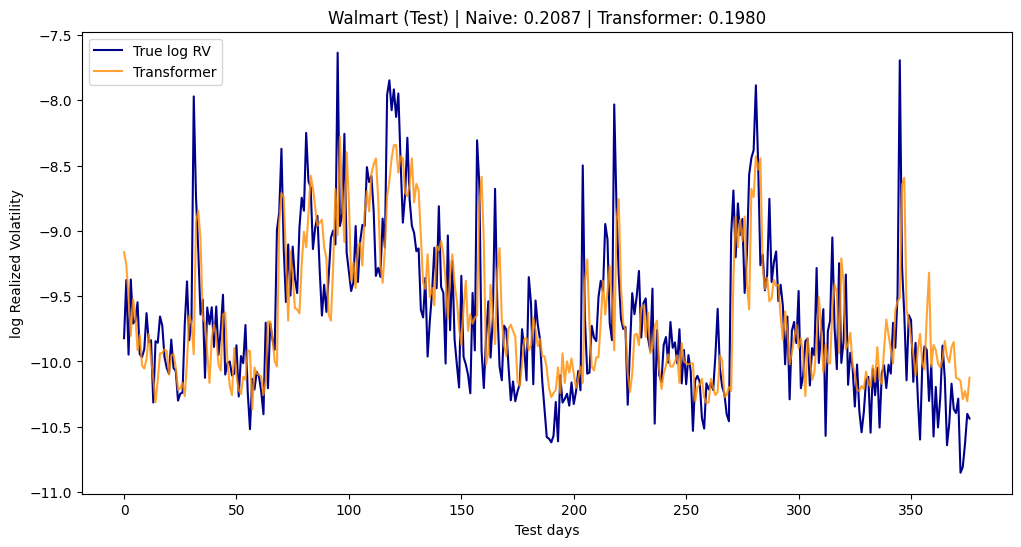

Saved plot to /content/drive/MyDrive/data/Walmart_dm512_h8_L8_ctx2.png



In [16]:
out = test_stocks(['/content/drive/MyDrive/data/stocks/Walmart.csv'], patch_len=1, train_frac=0.7, val_frac=0.15,
                n_days_context=2, add_calendar=False,
                d_model=512, nhead=8, num_layers=8,
                batch_size=64, lr=1e-3, max_epochs=50, patience = 5,
                save_dir="/content/drive/MyDrive/data")

In [28]:
#legacy plot
plt.figure(figsize=(12, 6))
plt.plot(yte_true_log, label="True log RV", color="darkblue")
#plt.plot(y_naive, label="Naive (yesterday=today)", linestyle="--")
plt.plot(yte_pred_log, label="Transformer", alpha=0.8, color = "darkorange")
plt.title(f"{stock_name} (Test) | Naive: {naive_mse:.4f} | Transformer: {te_mse:.4f}")
plt.xlabel("Test days")
plt.ylabel("log Realized Volatility")
plt.legend()
fig_path = os.path.join(save_dir, f"{stock_name}_dm{d_model}_h{nhead}_L{num_layers}_ctx{n_days_context}.png")
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()
print(f"Saved plot to {fig_path}\n")

NameError: name 'yte_true_log' is not defined

<Figure size 1200x600 with 0 Axes>